Importing Useful Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import clip
import pandas as pd
from IPython.display import display
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt 
import time
import gdown
import zipfile
import os
import cv2
import json
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer


In [ ]:
# Is this needed???
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    torch.cuda.empty_cache()

cuda


Displaying some sample images, their masks and phrases

In [ ]:
#Show examples of data by reading the CSV file - images, masks and their phrases
#Need to create CSV file with image_id, phrase and mask name that gets read in as a dataframe
df = pd.read_csv("train_data.csv")
for i in range(5):
    temp_ip = Image.open("/train/images/%s.jpg" % df['image_id'][i])
    display(temp_ip)
    temp_op = Image.open("train_mask/%s.jpg" % (str(df['image_id'][i]) + ".jpg_" + str(df['phrase'][i])))
    display(temp_op)
    print(df['phrase'][i])

Importing the CLIP model

In [ ]:
#Importing Clip model
#! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git

Creating DataLoader Class

In [2]:
#Creating custom dataloader class

class PhraseCutDataset(Dataset):
    def __init__(self, split = None):
        super(PhraseCutDataset, self).__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        if split == 'mini_train':
            df = pd.read_csv("train_data.csv")
            
            self.size = 1000
            
            self.phrases = df["phrase"][0:1000]
            self.tasks = df["task_id"][0:1000]
            self.input_images = []
            self.outputs = []
            for i in range(1000):
                temp_ip = Image.open("phrasecut_dataset/VGPhraseCut_V0_sub_train+val/train/images/%s.jpg" % df['image_id'][i])
                temp_op = Image.open("train_mask/%s.jpg" % (str(df['image_id'][i]) + ".jpg_" + str(self.phrases[i])))
                temp_ip = temp_ip.resize((352, 352))
                temp_op = temp_op.resize((224, 224))
                self.input_images.append(np.array(temp_ip, dtype=np.float32))
                self.outputs.append(np.array(temp_op, dtype = np.float32)/255)

        elif split == 'train':
            df = pd.read_csv("train_data.csv")
            
            self.size = 24001
            
            self.phrases = df["phrase"][0:24001]
            self.tasks = df["task_id"][0:24001]
            self.input_images = []
            self.outputs = []
            for i in range(24001):
                if(i % 1000 == 0):
                    print(f'{i} train images loaded')
                temp_ip = Image.open("phrasecut_dataset/VGPhraseCut_V0_sub_train+val/train/images/%s.jpg" % df['image_id'][i])
                temp_op = Image.open("train_mask/%s.jpg" % (str(df['image_id'][i]) + ".jpg_" + str(self.phrases[i])))
                temp_ip = temp_ip.resize((352, 352))
                temp_op = temp_op.resize((224, 224))
                self.input_images.append(np.array(temp_ip, dtype=np.float32))
                self.outputs.append(np.array(temp_op, dtype = np.float32)/255)

        elif split == 'val':
            df = pd.read_csv("val_data.csv")
            
            self.size = 994
            
            self.phrases = df["phrase"][0:994]
            self.tasks = df["task_id"][0:994]
            self.input_images = []
            self.outputs = []
            for i in range(994):
                temp_ip = Image.open("phrasecut_dataset/VGPhraseCut_V0_sub_train+val/val/images/%s.jpg" % df['image_id'][i])
                temp_op = Image.open("val_mask/%s.jpg" % (str(df['image_id'][i]) + ".jpg_" + str(self.phrases[i])))
                temp_ip = temp_ip.resize((352, 352))
                temp_op = temp_op.resize((224, 224))

                threshold = 128 
                temp_op = np.where(np.array(temp_op) >= threshold, 255, 0)
                
                self.input_images.append(np.array(temp_ip, dtype=np.float32))
                self.outputs.append(np.array(temp_op, dtype = np.float32)/255)

        elif split == 'test':
            df = pd.read_csv("val_data.csv")
            filtered_df = df.loc[1003:2002].reset_index(drop=True)
            self.size = 999
            
            self.phrases = filtered_df["phrase"][0:999]
            self.tasks = filtered_df["task_id"][0:999]
            self.input_images = []
            self.outputs = []
            for i in range(999): 
                temp_ip = Image.open("phrasecut_dataset/VGPhraseCut_V0_sub_train+val/val/images/%s.jpg" % filtered_df['image_id'][i])
                temp_op = Image.open("val_mask/%s.jpg" % (str(filtered_df['image_id'][i]) + ".jpg_" + str(self.phrases[i])))

                temp_ip = temp_ip.resize((352, 352))
                temp_op = temp_op.resize((224, 224))

                threshold = 128 
                temp_op = np.where(np.array(temp_op) >= threshold, 255, 0)

                self.input_images.append(np.array(temp_ip, dtype=np.float32))
                self.outputs.append(np.array(temp_op, dtype = np.float32)/255)
                
                
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.phrases[idx], self.input_images[idx], self.outputs[idx], self.tasks[idx]    

In [3]:
# Loading the mini_train dataset
tic = time.time()
data = PhraseCutDataset('mini_train')
mini_train = DataLoader(data, batch_size=1, shuffle=True)
toc = time.time()
print(f"mini_train set loaded. Time taken = {toc - tic} sec")

mini_train set loaded. Time taken = 7.2317094802856445 sec


In [4]:
# Loading the train dataset
tic = time.time()
data = PhraseCutDataset('train')
train = DataLoader(data, batch_size=1, shuffle=True)
toc = time.time()
print(f"train set loaded. Time taken = {toc - tic} sec")

0 train images loaded
1000 train images loaded
2000 train images loaded
3000 train images loaded
4000 train images loaded
5000 train images loaded
6000 train images loaded
7000 train images loaded
8000 train images loaded
9000 train images loaded
10000 train images loaded
11000 train images loaded
12000 train images loaded
13000 train images loaded
14000 train images loaded
15000 train images loaded
16000 train images loaded
17000 train images loaded
18000 train images loaded
19000 train images loaded
20000 train images loaded
21000 train images loaded
22000 train images loaded
23000 train images loaded
24000 train images loaded
train set loaded. Time taken = 204.85014462471008 sec


In [5]:
# Loading the val dataset
tic = time.time()
data = PhraseCutDataset('val')
val = DataLoader(data, batch_size=1, shuffle=True)
toc = time.time()
print(f"val set loaded. Time taken = {toc - tic} sec")

val set loaded. Time taken = 9.688658475875854 sec


In [6]:
# Loading the test dataset
tic = time.time()
data = PhraseCutDataset('test')
test = DataLoader(data, batch_size=1, shuffle=True)
toc = time.time()
print(f"test set loaded. Time taken = {toc - tic} sec")

test set loaded. Time taken = 10.523796796798706 sec


1. Using BCELoss

Encoder using CLIP model

In [12]:
from encoder_model import Encoder
encoder1 = Encoder()

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['text_projection.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'vision_model.encoder.layers.3.layer_norm2.weight', 'visual_projection.weight', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'logit_scale', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.mlp.fc2.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.post_layernorm.weight', 'vision_model.encoder.layers.5.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.mlp.fc1.b

In [11]:
print(encoder1)

Encoder(
  (model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=True)
       

In [12]:
num_e = sum(e.numel() for e in encoder1.parameters() if e.requires_grad)
print("No of trainable parameters in the encoder -", num_e)

No of trainable parameters in the encoder - 0


Creating custom Decoder

In [13]:
from decoder_model import Decoder

decoder1 = Decoder()

In [14]:
print(decoder1)

Decoder(
  (film_mul): Linear(in_features=512, out_features=128, bias=True)
  (film_add): Linear(in_features=512, out_features=128, bias=True)
  (reduce_blocks): ModuleList(
    (0-3): 4 x Linear(in_features=768, out_features=128, bias=True)
  )
  (mha_blocks): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (trans_conv): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [15]:
num_d = sum(d.numel() for d in decoder1.parameters() if d.requires_grad)
print("No of trainable parameters in the decoder -", num_d)

No of trainable parameters in the decoder - 3179969


Training Loop

In [15]:
# Hyper-parameters
import torch.optim.lr_scheduler as lr_scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(decoder1.parameters(), lr=1e-4)
gamma = 0.9
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [17]:
# Training Loop
n_total_steps = len(train)
loss_history = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (phrase, ip_image, op_image, _) in enumerate(train):
        if ip_image[0].dim() != 3:
            continue
        
        # Using CLIP to encode
        encodings = encoder1(transforms.ToPILImage()(ip_image[0].permute(2, 0, 1)).convert("RGB"), phrase[0])
            
        # Using a custom decoder
        output = decoder1(encodings)
        
        loss = criterion(output[0][0], op_image[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Printing the loss at regular intervals
        if (i+1) % 2000 == 0:
            print(f"loss at epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_total_steps}: {loss.item()}")
            loss_history.append(loss.item())

    # Step the scheduler after each epoch
    scheduler.step()

loss at epoch 1/10, iteration 2000/24001: 0.7014215588569641
loss at epoch 1/10, iteration 4000/24001: 0.6722689270973206
loss at epoch 1/10, iteration 6000/24001: 0.6422566771507263
loss at epoch 1/10, iteration 8000/24001: 0.6111579537391663
loss at epoch 1/10, iteration 10000/24001: 0.5951757431030273
loss at epoch 1/10, iteration 12000/24001: 0.6250544190406799
loss at epoch 1/10, iteration 14000/24001: 0.542205810546875
loss at epoch 1/10, iteration 16000/24001: 0.5960659980773926
loss at epoch 1/10, iteration 18000/24001: 0.5442551374435425
loss at epoch 1/10, iteration 20000/24001: 0.5011155605316162
loss at epoch 1/10, iteration 22000/24001: 0.5670962929725647
loss at epoch 1/10, iteration 24000/24001: 0.46695476770401
loss at epoch 2/10, iteration 2000/24001: 0.44678792357444763
loss at epoch 2/10, iteration 4000/24001: 0.45605769753456116
loss at epoch 2/10, iteration 6000/24001: 0.45217975974082947
loss at epoch 2/10, iteration 8000/24001: 0.4337829351425171
loss at epoch 2/

Saving the decoder weights

In [18]:
# Saving the decoder weights
torch.save(decoder1.state_dict(), "decoder1_BCELoss.pth")

Evaluating the model on Val set

In [39]:
# Calculating the accuracies based on pixel-by-pixel, iou and dice scores on the val set
sigmoid = nn.Sigmoid()
with torch.no_grad():
    accuracy_pixel_by_pixel = []
    accuracy_iou = []
    accuracy_dice_score = []
    
    n_total_steps = len(val)
    
    for i, (pharase, ip_image, op_image, _) in enumerate(val):

        encodings = encoder1(transforms.ToPILImage()(ip_image[0].permute(2, 0, 1)).convert("RGB"), phrase[0])
        output = decoder1(encodings)
        accuracy_pixel_by_pixel.append(torch.sum((output[0][0]>0) == op_image[0])/(224*224))

        output = sigmoid(output)
        
        intersection = torch.sum((output[0][0]>0)*op_image[0]) 
        union = torch.sum(output[0][0] > 0)+torch.sum(op_image[0]) - intersection
        accuracy_iou.append(intersection/union)
        
        numerator = 2*torch.sum((output[0][0]>0)*op_image[0]) + 1e-6
        denominator = torch.sum(op_image[0]**2) + torch.sum((output[0][0]>0)**2) + 1e-6
        accuracy_dice_score.append(numerator/denominator)
        
    print(f"accuracy pixel-by-pixel is - {100*sum(accuracy_pixel_by_pixel)/len(accuracy_pixel_by_pixel)}%")
    print(f"accuracy by iou is - {100*sum(accuracy_iou)/len(accuracy_iou)}%")
    print(f"accuracy by dice-scores is - {100*sum(accuracy_dice_score)/len(accuracy_dice_score)}%")

accuracy pixel-by-pixel is - 89.51485443115234%
accuracy by iou is - 10.485158920288086%
accuracy by dice-scores is - 16.220623016357422%


Evaluating the model on test set

In [89]:
# Calculating the accuracies based on pixel-by-pixel, iou and dice scores on the test set
sigmoid = nn.Sigmoid()
with torch.no_grad():
    accuracy_pixel_by_pixel = []
    accuracy_iou = []
    accuracy_dice_score = []
    
    n_total_steps = len(test)
    
    for i, (pharase, ip_image, op_image, _) in enumerate(test):
        encodings = encoder1(transforms.ToPILImage()(ip_image[0].permute(2, 0, 1)).convert("RGB"), phrase[0])
        output = decoder1(encodings)
        accuracy_pixel_by_pixel.append(torch.sum((output[0][0]>0) == op_image[0])/(224*224))

        output = sigmoid(output)
        
        intersection = torch.sum((output[0][0]>0)*op_image[0]) 
        union = torch.sum(output[0][0] > 0)+torch.sum(op_image[0]) - intersection
        accuracy_iou.append(intersection/union)
        
        numerator = 2*torch.sum((output[0][0]>0)*op_image[0]) + 1e-6
        denominator = torch.sum(op_image[0]**2) + torch.sum((output[0][0]>0)**2) + 1e-6
        accuracy_dice_score.append(numerator/denominator)
        
    print(f"accuracy by pixel-by-pixel is - {100*sum(accuracy_pixel_by_pixel)/len(accuracy_pixel_by_pixel) :.6f}%")
    print(f"accuracy by iou is - {100*sum(accuracy_iou)/len(accuracy_iou) :.6f}%")
    print(f"accuracy by dice-scores is - {100*sum(accuracy_dice_score)/len(accuracy_dice_score) :.6f}%")

accuracy by pixel-by-pixel is - 90.381027%
accuracy by iou is - 9.618964%
accuracy by dice-scores is - 15.002020%


Running it on a random image from val_data

In [87]:
with torch.no_grad():
    encodings = encoder1(Image.open("phrasecut_dataset\VGPhraseCut_V0_sub_train+val\\val\images\\2365666.jpg"), "sheep grazing field")
    output = decoder1(encodings)
    output = sigmoid(output)
    threshold = (output.max() + output.min())/2
    output = (output >= threshold).float()
    output = output[0][0]
    print(type(output), output.size(), torch.unique(output))
    img = transforms.ToPILImage()(output)
    img.show()

<class 'torch.Tensor'> torch.Size([224, 224]) tensor([0., 1.])


Plotting Loss History

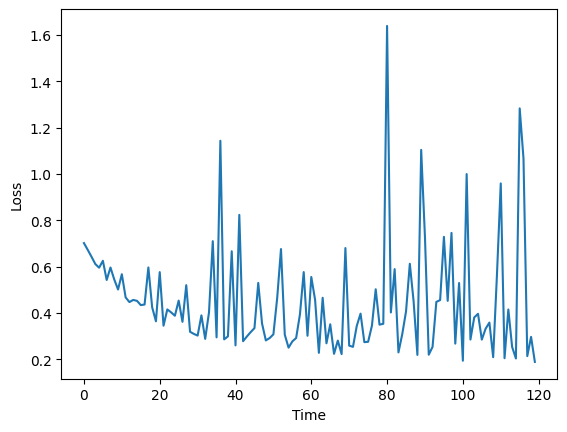

In [20]:
#Plot of loss history
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

2. Using DICE Loss

Encoder using CLIP model

In [7]:
from encoder_model import Encoder
encoder2 = Encoder()

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'text_projection.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.layer_norm2.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.self_

In [8]:
print(encoder2)

Encoder(
  (model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=True)
       

In [9]:
num_e = sum(e.numel() for e in encoder2.parameters() if e.requires_grad)
print("No of trainable parameters in the encoder -", num_e)

No of trainable parameters in the encoder - 0


Creating custom Decoder

In [10]:
from decoder_model import Decoder

decoder2 = Decoder()

In [11]:
print(decoder2)

Decoder(
  (film_mul): Linear(in_features=512, out_features=128, bias=True)
  (film_add): Linear(in_features=512, out_features=128, bias=True)
  (reduce_blocks): ModuleList(
    (0-3): 4 x Linear(in_features=768, out_features=128, bias=True)
  )
  (mha_blocks): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (trans_conv): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [12]:
num_d = sum(d.numel() for d in decoder2.parameters() if d.requires_grad)
print("No of trainable parameters in the decoder -", num_d)

No of trainable parameters in the decoder - 3179969


Training Loop

In [13]:
class DICELoss(nn.Module): 
    def __init__(self, alpha=0.7, smooth=1):
        super(DICELoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        
    def forward(self, y_pred, y_true):
        y_pred_pos = torch.sigmoid(y_pred)
        
        y_pred_pos = y_pred_pos.view(-1)
        y_true = y_true.view(-1)
        
        TP = (y_pred_pos * y_true).sum()    
       
        dice_score = (2*TP + self.smooth) / (2*TP + y_pred_pos.sum() + y_true.sum() + self.smooth)
        
        return 1 - dice_score

In [14]:
# Hyper-parameters
import torch.optim.lr_scheduler as lr_scheduler
criterion = DICELoss()
optimizer = torch.optim.SGD(decoder2.parameters(), lr=1e-4)
gamma = 0.9
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [15]:
# Training Loop
n_total_steps = len(train)
loss_history = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (phrase, ip_image, op_image, _) in enumerate(train):
        if ip_image[0].dim() != 3:
            continue
        
        # Using CLIP to encode
        encodings = encoder2(transforms.ToPILImage()(ip_image[0].permute(2, 0, 1)).convert("RGB"), phrase[0])
            
        # Using a custom decoder
        output = decoder2(encodings)
        
        loss = criterion(output[0][0], op_image[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Printing the loss at regular intervals
        if (i+1) % 2000 == 0:
            print(f"loss at epoch {epoch+1}/{num_epochs}, iteration {i+1}/{n_total_steps}: {loss.item()}")
            loss_history.append(loss.item())

    # Step the scheduler after each epoch
    scheduler.step()

loss at epoch 1/10, iteration 2000/24001: 0.7690305709838867
loss at epoch 1/10, iteration 4000/24001: 0.9905737042427063
loss at epoch 1/10, iteration 6000/24001: 0.9686517715454102
loss at epoch 1/10, iteration 8000/24001: 0.6033329963684082
loss at epoch 1/10, iteration 10000/24001: 0.8289849758148193
loss at epoch 1/10, iteration 12000/24001: 0.8551714420318604
loss at epoch 1/10, iteration 14000/24001: 0.9921943545341492
loss at epoch 1/10, iteration 16000/24001: 0.931995689868927
loss at epoch 1/10, iteration 18000/24001: 0.7750867009162903
loss at epoch 1/10, iteration 20000/24001: 0.8315820693969727
loss at epoch 1/10, iteration 22000/24001: 0.8490604162216187
loss at epoch 1/10, iteration 24000/24001: 0.7683706879615784
loss at epoch 2/10, iteration 2000/24001: 0.8586768507957458
loss at epoch 2/10, iteration 4000/24001: 0.8838991522789001
loss at epoch 2/10, iteration 6000/24001: 0.7216893434524536
loss at epoch 2/10, iteration 8000/24001: 0.7167798280715942
loss at epoch 2/1

Saving the decoder weights

In [16]:
# Saving the decoder weights
torch.save(decoder2.state_dict(), "decoder2_DICELoss.pth")

Evaluating the model on Val set

In [17]:
# Calculating the accuracies based on pixel-by-pixel, iou and dice scores on the val set
sigmoid = nn.Sigmoid()
with torch.no_grad():
    accuracy_pixel_by_pixel = []
    accuracy_iou = []
    accuracy_dice_score = []
    
    n_total_steps = len(val)
    
    for i, (pharase, ip_image, op_image, _) in enumerate(val):

        encodings = encoder2(transforms.ToPILImage()(ip_image[0].permute(2, 0, 1)).convert("RGB"), phrase[0])
        output = decoder2(encodings)
        accuracy_pixel_by_pixel.append(torch.sum((output[0][0]>0) == op_image[0])/(224*224))

        output = sigmoid(output)
        
        intersection = torch.sum((output[0][0]>0)*op_image[0]) 
        union = torch.sum(output[0][0] > 0)+torch.sum(op_image[0]) - intersection
        accuracy_iou.append(intersection/union)
        
        numerator = 2*torch.sum((output[0][0]>0)*op_image[0]) + 1e-6
        denominator = torch.sum(op_image[0]**2) + torch.sum((output[0][0]>0)**2) + 1e-6
        accuracy_dice_score.append(numerator/denominator)
        
    print(f"accuracy pixel-by-pixel is - {100*sum(accuracy_pixel_by_pixel)/len(accuracy_pixel_by_pixel)}%")
    print(f"accuracy by iou is - {100*sum(accuracy_iou)/len(accuracy_iou)}%")
    print(f"accuracy by dice-scores is - {100*sum(accuracy_dice_score)/len(accuracy_dice_score)}%")

accuracy pixel-by-pixel is - 10.485163688659668%
accuracy by iou is - 10.485163688659668%
accuracy by dice-scores is - 16.220609664916992%


Evaluating the model on test set

In [18]:
# Calculating the accuracies based on pixel-by-pixel, iou and dice scores on the test set
sigmoid = nn.Sigmoid()
with torch.no_grad():
    accuracy_pixel_by_pixel = []
    accuracy_iou = []
    accuracy_dice_score = []
    
    n_total_steps = len(test)
    
    for i, (pharase, ip_image, op_image, _) in enumerate(test):
        encodings = encoder2(transforms.ToPILImage()(ip_image[0].permute(2, 0, 1)).convert("RGB"), phrase[0])
        output = decoder2(encodings)
        accuracy_pixel_by_pixel.append(torch.sum((output[0][0]>0) == op_image[0])/(224*224))

        output = sigmoid(output)
        
        intersection = torch.sum((output[0][0]>0)*op_image[0]) 
        union = torch.sum(output[0][0] > 0)+torch.sum(op_image[0]) - intersection
        accuracy_iou.append(intersection/union)
        
        numerator = 2*torch.sum((output[0][0]>0)*op_image[0]) + 1e-6
        denominator = torch.sum(op_image[0]**2) + torch.sum((output[0][0]>0)**2) + 1e-6
        accuracy_dice_score.append(numerator/denominator)
        
    print(f"accuracy by pixel-by-pixel is - {100*sum(accuracy_pixel_by_pixel)/len(accuracy_pixel_by_pixel) :.6f}%")
    print(f"accuracy by iou is - {100*sum(accuracy_iou)/len(accuracy_iou) :.6f}%")
    print(f"accuracy by dice-scores is - {100*sum(accuracy_dice_score)/len(accuracy_dice_score) :.6f}%")

accuracy by pixel-by-pixel is - 9.618974%
accuracy by iou is - 9.618974%
accuracy by dice-scores is - 15.002019%


Running it on a random image from val_data

In [19]:
with torch.no_grad():
    encodings = encoder2(Image.open("phrasecut_dataset\VGPhraseCut_V0_sub_train+val\\val\images\\2365666.jpg"), "sheep grazing field")
    output = decoder2(encodings)
    output = sigmoid(output)
    threshold = (output.max() + output.min())/2
    output = (output >= threshold).float()
    output = output[0][0]
    print(type(output), output.size(), torch.unique(output))
    img = transforms.ToPILImage()(output)
    img.show()

<class 'torch.Tensor'> torch.Size([224, 224]) tensor([0., 1.])


Plotting Loss History

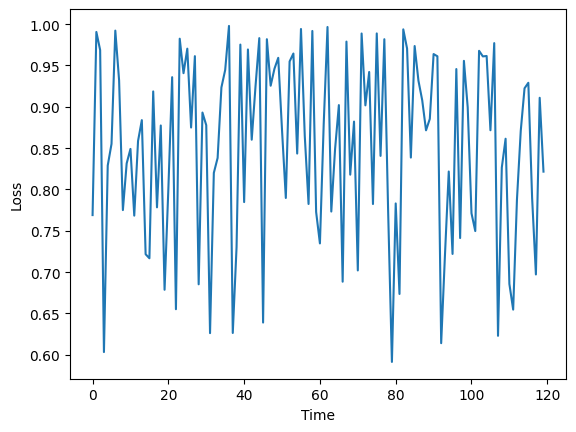

In [20]:
#Plot of loss history
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()